/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:116: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.


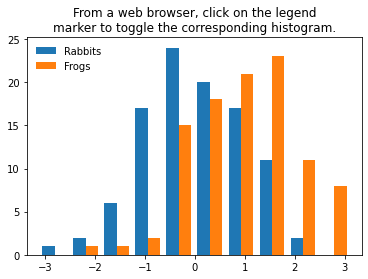

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from io import BytesIO
import json


plt.rcParams['svg.fonttype'] = 'none'

# Apparently, this `register_namespace` method is necessary to avoid garbling
# the XML namespace with ns0.
ET.register_namespace("", "http://www.w3.org/2000/svg")

# Fixing random state for reproducibility
np.random.seed(19680801)

# --- Create histogram, legend and title ---
plt.figure()
r = np.random.randn(100)
r1 = r + 1
labels = ['Rabbits', 'Frogs']
H = plt.hist([r, r1], label=labels)
containers = H[-1]
leg = plt.legend(frameon=False)
plt.title("From a web browser, click on the legend\n"
          "marker to toggle the corresponding histogram.")


# --- Add ids to the svg objects we'll modify

hist_patches = {}
for ic, c in enumerate(containers):
    hist_patches['hist_%d' % ic] = []
    for il, element in enumerate(c):
        element.set_gid('hist_%d_patch_%d' % (ic, il))
        hist_patches['hist_%d' % ic].append('hist_%d_patch_%d' % (ic, il))

# Set ids for the legend patches
for i, t in enumerate(leg.get_patches()):
    t.set_gid('leg_patch_%d' % i)

# Set ids for the text patches
for i, t in enumerate(leg.get_texts()):
    t.set_gid('leg_text_%d' % i)

# Save SVG in a fake file object.
f = BytesIO()
plt.savefig(f, format="svg")

# Create XML tree from the SVG file.
tree, xmlid = ET.XMLID(f.getvalue())


# --- Add interactivity ---

# Add attributes to the patch objects.
for i, t in enumerate(leg.get_patches()):
    el = xmlid['leg_patch_%d' % i]
    el.set('cursor', 'pointer')
    el.set('onclick', "toggle_hist(this)")

# Add attributes to the text objects.
for i, t in enumerate(leg.get_texts()):
    el = xmlid['leg_text_%d' % i]
    el.set('cursor', 'pointer')
    el.set('onclick', "toggle_hist(this)")

# Create script defining the function `toggle_hist`.
# We create a global variable `container` that stores the patches id
# belonging to each histogram. Then a function "toggle_element" sets the
# visibility attribute of all patches of each histogram and the opacity
# of the marker itself.

script = """
<script type="text/ecmascript">
<![CDATA[
var container = %s

function toggle(oid, attribute, values) {
    /* Toggle the style attribute of an object between two values.

    Parameters
    ----------
    oid : str
      Object identifier.
    attribute : str
      Name of style attribute.
    values : [on state, off state]
      The two values that are switched between.
    */
    var obj = document.getElementById(oid);
    var a = obj.style[attribute];

    a = (a == values[0] || a == "") ? values[1] : values[0];
    obj.style[attribute] = a;
    }

function toggle_hist(obj) {

    var num = obj.id.slice(-1);

    toggle('leg_patch_' + num, 'opacity', [1, 0.3]);
    toggle('leg_text_' + num, 'opacity', [1, 0.5]);

    var names = container['hist_'+num]

    for (var i=0; i < names.length; i++) {
        toggle(names[i], 'opacity', [1, 0])
    };
    }
]]>
</script>
""" % json.dumps(hist_patches)

# Add a transition effect
css = tree.getchildren()[0][0]
css.text = css.text + "g {-webkit-transition:opacity 0.4s ease-out;" + \
    "-moz-transition:opacity 0.4s ease-out;}"

# Insert the script and save to file.
tree.insert(0, ET.XML(script))

ET.ElementTree(tree).write("svg_histogram.svg")